In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import sys
sys.path.append('/Users/af/Work/Cosmo/codes/1d/build')

import extruct
import numpy as np
import matplotlib.pyplot as plt

from classy import Class

directory = 'data'
#filename = 'SPT_orders_fine_trap3.dat'
filename = 'simulation_data.pk'


def isfloat(value):
    try: 
        float(value)
        return True 
    except ValueError:
        return False  

fp = open(directory + "/" + filename)    
lines = fp.readlines()

data = [[float(v) for v in line.split()] for line in lines if all([isfloat(word) for word in line.split()]) ]
data = np.array(data)

kf = data[:,0]
pkfnl = data[:,1]
pkf = data[:,2]
pkfzel = data[:,3]

    
    

my sigma8:
1.6928322474852475


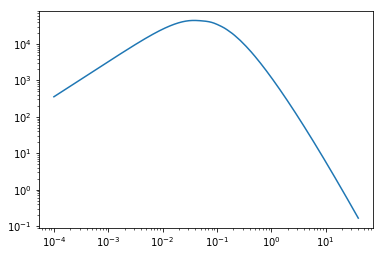

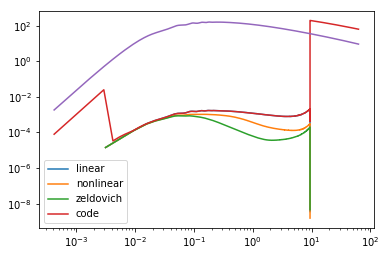

In [32]:
# h = 0.7
# Om = 0.3
# bg = extruct.Background()
# bg = extruct.Background(50, 0, Om, h, 0)
# bg.integrate()

# t = np.zeros(N)
# D1 = np.zeros(N)
# D2 = np.zeros(N)
# i = 0
# taufin = 60
# for tau in np.linspace(0,taufin,N): 
#     a[i] = bg.getScaleFactor(tau)
#     D1[i] = bg.getD1(tau)
#     D2[i] = bg.getD2(tau)
#     t[i] = bg.getPhysTime(tau)
#     i = i+1
    

    
# plt.plot(a2, a2-1/(1+zs))
# plt.show()
# plt.figure(figsize=(10, 10), dpi= 200)
# plt.plot(a, D1)
# plt.plot(a, 0.4*a/h/Om, '.')
# plt.show()

#plt.figure(figsize=(10, 10), dpi= 200)
#plt.semilogy(a, D2)
#plt.semilogy(a, np.sqrt(Om/a**3 + 1 - Om), '.')

#plt.figure(figsize=(10, 10), dpi= 200)
#plt.plot(a, np.gradient(np.gradient(D1))/(taufin/N)**2)
#plt.plot(a, 1.5*Om*a*D1*h**2)
#plt.show()

zin = 100
zfin = 0


h = 0.7 #674
omh2 = 0.12
obh2 = 0.0244

Om = (omh2+obh2)/h**2
Om = 0.99


L = 5
Oc = 0

bg = extruct.Background(zin, zfin, Om, h, Oc)

bg.integrate()


BBKS = extruct.BBKS(bg, L, True, False, obh2)
BBKS.A = (0.848365/0.75147)**2 #0.5/bg.getGrowth(0)**2
#BBKS.n = 0.965

nBins = 6000
kk = np.logspace(-4,np.log10(40),nBins)
Pk = []
for k in kk:
    Pk.append(BBKS.eval(k))
    
    
from scipy.integrate import simps

eight = 8/h # to comply with CLASS

mysigma8 = simps(Pk*kk**2/(2*np.pi**2)*(3*(kk*eight*np.cos(kk*eight) - np.sin(kk*eight))/(kk*eight)**3)**2, kk)**0.5

print("my sigma8:")
print(mysigma8)
    
plt.loglog(kk, Pk) 
plt.show()
    
#sigma8 = 0.848365
sigma8 = mysigma8 

LambdaCDM = Class()  #0.965 
LambdaCDM.set({'model':0,'omega_b':obh2,'omega_cdm':omh2,'h':h,'sigma8':mysigma8,'n_s':0.965,'tau_reio':0.0925})
LambdaCDM.set({'output':'mPk','P_k_max_1/Mpc':155.0})
# run class
LambdaCDM.compute()



N = 5000
D = np.zeros(N)
#a2 = np.zeros(N)

zs = np.linspace(zin,zfin,N)
i = 0
for z in zs:
    D[i] = bg.getGrowth(z)
    i = i+1
    
#plt.plot(zs, D)
#plt.show()



pk = np.zeros(50000)
pkclass = np.zeros(50000)
k = np.zeros(50000)


for i in range(pk.size):
    ki = i*2*np.pi/(L*2997.92348)
    if ki > kf[0] and ki < kf[-1]: 
        pki = np.interp(ki, kf, pkf)
        pki = pki/(L*2997.92348)/bg.getGrowth(0)**2
        pk[i] = BBKS.set_dimless(i, pki)
    
    
for i in range(pk.size):
    k[i] = (3*i+1)*2*np.pi/(L*2997.92348)
    pk[i] = BBKS.eval_dimless(3*i+1)*(L*2997.92348)
    pkclass[i] = LambdaCDM.pk(k[i],0)*(k[i]**2)/np.pi #*0.93#*0.81


plt.loglog(kf, pkf/bg.getGrowth(0)**2)
plt.loglog(kf, pkfnl/bg.getGrowth(0)**2)
plt.loglog(kf, pkfzel/bg.getGrowth(0)**2)
plt.loglog(k, pk)
plt.legend(["linear", "nonlinear", "zeldovich", "code"])
plt.loglog(k, pkclass)
plt.show()

#plt.semilogx(k, (pk-pkclass)/pkclass)
#plt.show()

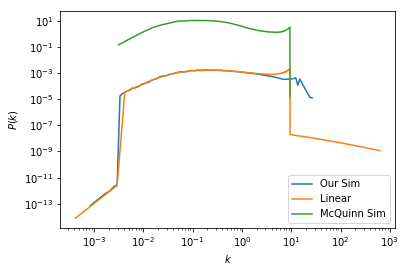

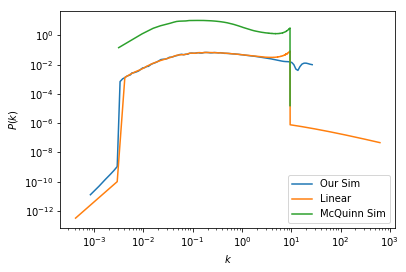

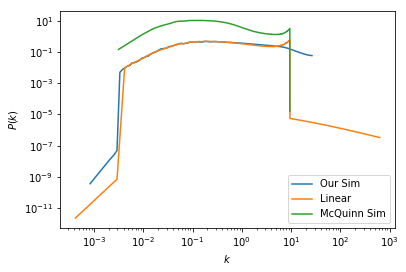

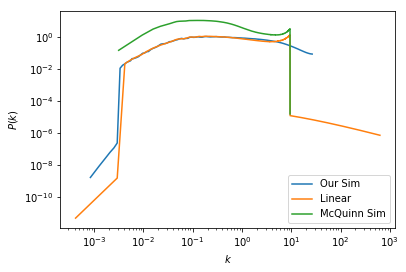

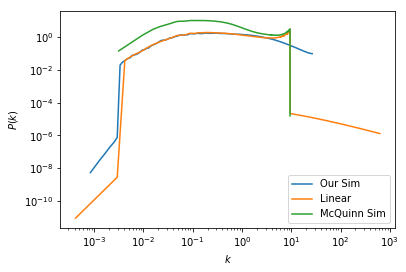

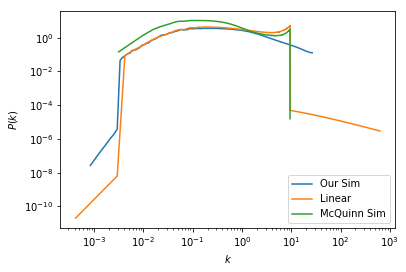

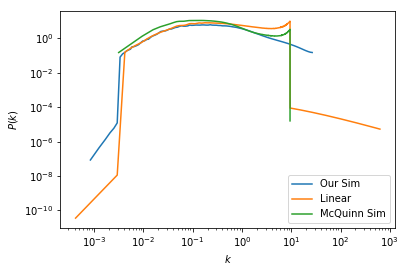

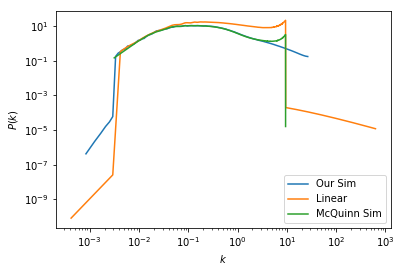

In [18]:
def running_mean(x, N):
    #cumsum = np.cumsum(np.insert(x, 0, 0)) 
    #return (cumsum[N:] - cumsum[:-N]) / float(N)
    return x
    #return np.convolve(x, np.ones((N,))/N, mode='valid')

#nParticles = 1024*64*8
nParticles = 1024*8*8
god = extruct.Multiverse(0)


#pspec.A = 0.00000000004


# 1. Densities, 16*1024 particles
# 2. 1024 particles, Pk
# 3. change to 256 
# 4. change back to 100, 2*1024 particles, 200 universes

for i in range(1,400):
    god.bang(nParticles, bg, BBKS, L, 1) 
  
#m_den = extruct.DensityObs(100)

#god.measure(uni1, m_den)

denObs = extruct.DensityObs(100)
denObs2 = extruct.DensityObs2(200)
dispObs = extruct.DisplacementField(1024)
collObs = extruct.CollisionObs(500)


pkObs1 = extruct.PowerSpectrumObs(0,np.int(80),L, np.int(2*nParticles/128/8))
pkObs2 = extruct.PowerSpectrumObs(1,np.int(80),L,np.int(2*nParticles/64/4)) #can do 512 for single universe with 1024
pkObsFFT = extruct.PowerSpectrumObs(2, np.int(110),L,1)


psdenObs = extruct.PhaseSpaceDensityObs(300)
#corrObs = extruct.CorrelationFunctionObs(0, 1000)
#pk3DObsDeriv = extruct.PowerSpectrum3DObs(0, 4096)
#pk3DObsFFT = extruct.PowerSpectrum3DObs(1, 4096)

for z in [zin-0.0001, 15, 5, 3, 2, 1, 0.5, 0]: #[zin-1, 50, 20, 10, 5, 3, 2, 1.5, 1, 0.75, 0.5, 0.25, 0]:

    god.evolveAll(z)

#    god.measureAll(pkObs1)
    
    
    
    
 #   god.measureAll(pkObsFFT)
    
#    god.measureAll(denObs)

#    god.measureAll(corrObs)

 #   god.measureAll(pk3DObsDeriv)

#    pk1 = pkObs1.getResult()
    
#     ##################################

#     god.measureAll(denObs2)
#     god.measureAll(psdenObs)
#     god.measureAll(collObs)

#     den2 = denObs2.getResult()
#     disp = dispObs.getResult()
#     psden = psdenObs.getResult()
#     coll = collObs.getResult()
    
    
#     plt.imshow(np.log(psden.T), interpolation='nearest')
#     plt.show()
#     plt.plot(den2[0,:]-0.5,den2[1,:])
#     plt.show()
#     plt.plot(coll[0,:]-0.5,coll[1,:])
#     plt.show()
    
    ###################################
    
#    god.measureAll(pkObs2)
    god.measureAll(pkObsFFT)
#    pk2 = pkObs2.getResult()
    pkFFT = pkObsFFT.getResult()
#    plt.loglog(pk2[0,1:], pk2[1,1:])
    plt.loglog(pkFFT[0,1:], pkFFT[1,1:])
    plt.loglog(k, bg.getGrowth(z)**2*pk)
    plt.loglog(kf, pkfnl)
    plt.legend(["Our Sim", "Linear", "McQuinn Sim"])
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.show()
    
    
########

#     god.measureAll(dispObs)
#     disp = dispObs.getResult()
#     plt.plot(disp[0,:])
#     plt.show()

###################
    
   # pk22 = pkObs2.getResult()
 #   pkFFT = pkObsFFT.getResult()
 #   den = denObs.getResult()
    
 #   coll = collObs.getResult()
    
 #   corr = corrObs.getResult()


#    pk3DFFT = pk3DObsFFT.getResult()
#    pk3DDeriv = pk3DObsDeriv.getResult()

#     plt.plot(pkFFT[1,2000:2100])
#     plt.show
    
#     plt.plot(disp[0,1:50])
#     plt.show()
#     k=np.linspace(0,disp.size*np.pi*2,disp.size)
#     ft = np.fft.fft(disp[0,:])*k;
#     fth = np.split(ft,2)[0] 
#     kh = np.split(k,2)[0]
#     plt.loglog(kh,fth * np.conj(fth))
#     plt.show()
    
   
#    plt.loglog(pkFFT[0,1:], pkFFT[1,1:],50)
#    plt.ylim(1e-6, 1e-4)
#    plt.show()
#    plt.loglog(pk2[0,1:],pk2[1,1:])



#    plt.ylim(1e-6, 1e-4)
#     #plt.ylim(1e-3, 1)
#    plt.show()
#    plt.loglog(pk1[0,1:],pk1[1,1:])
#    plt.show()
    
    
 #   plt.loglog(pk3DDeriv[0,:], running_mean(np.abs(pk3DDeriv[1,:]),2))
 #   plt.loglog(pk3DFFT[0,:], running_mean(np.abs(pk3DFFT[1,:]),2))
 #   plt.show()
    
    
    
#    plt.loglog(pk1[0,:],pk1[1,:])
#    plt.loglog(pkFFT[0,:],pkFFT[1,:])
 #   plt.loglog(pk2[0,:],pk2[1,:])
 #   plt.show()
   


 #   plt.figure(figsize=(50, 50)) #, dpi= 200)
    
    #plt.plot(den[0,:]-0.5,den[1,:])
    
    
    #plt.plot(pk[0,:],pk[1,:])
  #  plt.show()
  #  plt.plot(corr[0,:],corr[1,:])
    
   # plt.show()
    
    

(-0.1, 0.1)

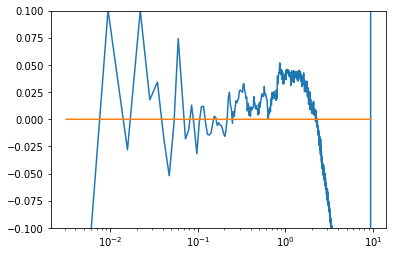

In [24]:
plt.semilogx(kf, (np.interp(kf, pkFFT[0,1:], pkFFT[1,1:]) - pkfnl)/pkfnl)
plt.semilogx(kf, 0*kf)
plt.ylim(-0.1, 0.1)


(-1, 1)

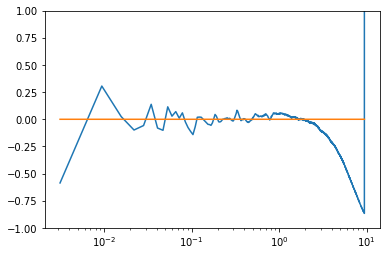

In [17]:
plt.semilogx(kf, (np.interp(kf, pkFFT[0,1:], pkFFT[1,1:]) - pkfnl)/pkfnl)
plt.semilogx(kf, 0*kf)
plt.ylim(-1, 1)

array([[ 1.5154046e-21,  1.4012985e-45,  1.5216763e-21,  1.4012985e-45,
         1.5216777e-21,  1.4012985e-45,  1.5414283e-44,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  1.1210388e-44,  0.0000000e+00,
         0.0000000e+00,  1.4012985e-45,  8.0282197e-28,  1.4012985e-45,
         0.0000000e+00,  0.0000000e+00, -1.1187908e+33,  4.5833670e-41,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         1.6815582e-44,  1.4012985e-45,  0.0000000e+00,  0.0000000e+00,
         1.6815582e-43,  7.8472714e-44,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.00000

In [8]:
uni1

0